In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

TEXT_DATA = '/content/fake_or_real_news.csv'

In [ ]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)

    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)

    return train_acc, test_acc

In [ ]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange:
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term

    return lb, ub

In [ ]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [ ]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


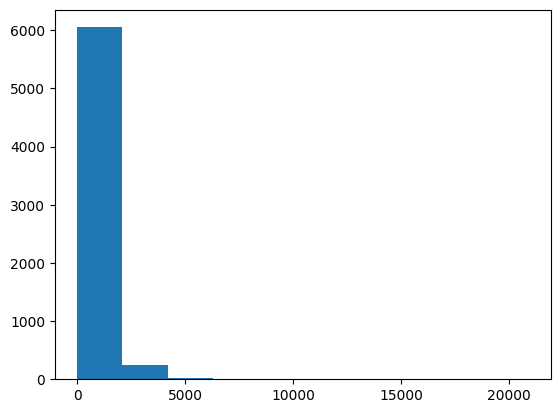

In [ ]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [ ]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word",
                             binary = True,
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names_out())

In [ ]:
# create training and test data

from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [ ]:
# Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB()

In [ ]:
# evaluate model

train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 94.46%
Testing Accuracy: 88.56%


In [ ]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 86.80%-90.31%


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer # Keras is part of tensorflow, so import from there
from tensorflow.keras.preprocessing.sequence import pad_sequences # Keras is part of tensorflow, so import from there

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [ ]:
!pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
# split the data into a training set and a validation set

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data,
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1),
                                                  test_size=TEST_SPLIT)

In [ ]:
# build a 1D convnet with global maxpooling

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),

        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=2,
                    validation_data=(x_val, y_val))

Epoch 1/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 800s 20s/step - accuracy: 0.5651 - loss: 0.6703 - val_accuracy: 0.7640 - val_loss: 0.5041
Epoch 2/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 845s 21s/step - accuracy: 0.8092 - loss: 0.4136 - val_accuracy: 0.9029 - val_loss: 0.2615


In [ ]:
# all possible parameters history stores
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

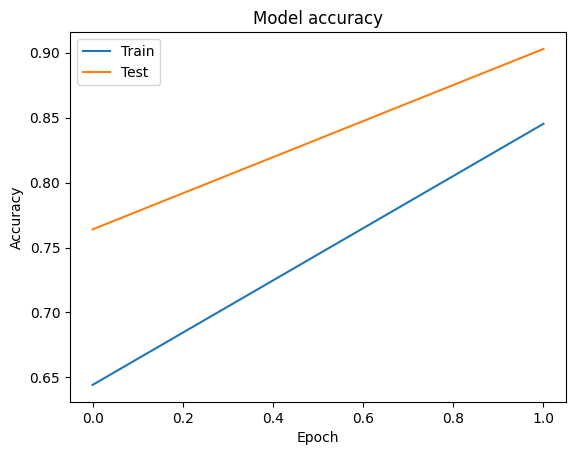

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# evaluate model

train_acc, test_acc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train,
                                     y_train,
                                     x_val,
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

159/159 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step
Training Accuracy: 92.48%
Testing Accuracy: 90.29%


In [ ]:
# estimate 95% confidence interval

n = x_val.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 88.66%-91.92%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_text(text, tokenizer, max_sequence_length=MAX_SEQUENCE_LENGTH):
    """
    Preprocess a single news article for prediction.
    """
    # Tokenize the text
    sequence = tokenizer.texts_to_sequences([text])
    # Pad the sequence to match the training data shape
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='pre', truncating='pre')
    return padded_sequence

def predict_news(model, tokenizer, news_text):
    """
    Predict whether the news is REAL or FAKE.
    """
    # Preprocess the news text
    preprocessed_text = preprocess_text(news_text, tokenizer)
    # Make prediction
    prediction = model.predict(preprocessed_text)
    # Convert prediction to label
    prediction_label = 'REAL' if np.rint(prediction) == 1 else 'FAKE'
    return prediction_label

# Prompt the user for input
while True:
    news_input = input("ENTER THE NEWS")

    if news_input.lower() == 'exit':
        break

    # Use the trained model and tokenizer for live prediction
    prediction = predict_news(model, tokenizer, news_input)
    print(f"The predicted label for the entered news article is: {prediction}")
    #Police pull up social media users for ‘ fake news’ of rape in Tirupati
    #U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sundayâ€™s unity march against terrorism.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
The predicted label for the entered news article is: REAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
The predicted label for the entered news article is: FAKE


In [ ]:
!pip install Flask flask-ngrok

In [ ]:
from flask import Flask, render_template_string, request
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/', methods=['GET', 'POST'])
def index():
    greeting = ''
    if request.method == 'POST':
        user_name = request.form['name']
        greeting = f'Hello, {user_name}!'
    return render_template_string("""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>User Input Example</title>
    </head>
    <body>
        <h1>Input Your Name</h1>
        <form method="POST">
            <input type="text" name="name" placeholder="Enter your name" required>
            <button type="submit">Submit</button>
        </form>
        {% if greeting %}
            <h2>{{ greeting }}</h2>
        {% endif %}
    </body>
    </html>
    """, greeting=greeting)

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 199, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll